# Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import datetime, time
import math
import numpy as np
from tqdm.auto import tqdm
import sys

In [2]:
from functions import *

# Exercise 1

#### Explore data and find the max and min timestamps

In [3]:
#create 3 dataframe
a2q=pd.read_csv('data/sx-stackoverflow-a2q.txt',sep=' ', names=['u','v','t'])  #answers to questions
c2a=pd.read_csv('data/sx-stackoverflow-c2a.txt',sep=' ', names=['u','v','t'])  #comments to answers
c2q=pd.read_csv('data/sx-stackoverflow-c2q.txt',sep=' ', names=['u','v','t'])  #comments to questions

In [4]:
def findTimeMaxMin(data,max,min): #Retrieve maximum and minimum timestamps
    m = data['t'].min()
    M = data['t'].max()
    if m < min:
        min = m 
    if M > max:
        max = M
    return max, min

In [5]:
#Search maximum and minimum timestamps on top of 3 dataset files
max=0
min=1638921630 #2021/12/08
max,min=findTimeMaxMin(a2q,max,min)
max,min=findTimeMaxMin(c2a,max,min)
max,min=findTimeMaxMin(c2q,max,min)


print("\nMaximum timestamp is:",datetime.datetime.fromtimestamp(max).strftime("%Y-%m-%d"),sep=" ")
print("\nMinimum timestamp is:",datetime.datetime.fromtimestamp(min).strftime("%Y-%m-%d"),sep=" ")


Maximum timestamp is: 2011-06-09

Minimum timestamp is: 2008-08-01


##### I choose to *study* data from 2008/08/01 to 2008/10/01

In [94]:
t_start = min
t_end = datetime.datetime(2008, 9, 1, 0, 0)
t_end = time.mktime(t_end.timetuple())
t_end

1220220000.0

In [95]:
G = nx.DiGraph() #create my graph

In [96]:
A = nx.DiGraph()
B = nx.DiGraph()
C = nx.DiGraph()

In [97]:
A.edges(data=True)
B.edges(data=True)
C.edges(data=True)

OutEdgeDataView([])

In [98]:
createWeightedGraph(A, a2q, t_start, t_end)
createWeightedGraph(B, c2a, t_start, t_end)
createWeightedGraph(C, c2q, t_start, t_end)

In [99]:
G = nx.compose_all([A, B, C])

In [12]:
G.edges(data=True)

OutEdgeDataView([(9.0, 8.0, {'weight': 1, 'timestamp': [1217567877.0]}), (9.0, 72.0, {'weight': 1, 'timestamp': [1217638074.0]}), (9.0, 404.0, {'weight': 1, 'timestamp': [1218112950.0]}), (1.0, 1.0, {'weight': 1, 'timestamp': [1217573801.0]}), (1.0, 233.0, {'weight': 2, 'timestamp': [1217843107.0, 1217849462.0]}), (1.0, 67.0, {'weight': 1, 'timestamp': [1217862281.0]}), (13.0, 1.0, {'weight': 1, 'timestamp': [1217606247.0]}), (13.0, 23.0, {'weight': 2, 'timestamp': [1217618560.0, 1217623216.0]}), (13.0, 11.0, {'weight': 1, 'timestamp': [1217618799.0]}), (13.0, 25.0, {'weight': 1, 'timestamp': [1217755970.0]}), (13.0, 85.0, {'weight': 1, 'timestamp': [1217847892.0]}), (13.0, 13.0, {'weight': 1, 'timestamp': [1217856138.0]}), (13.0, 236.0, {'weight': 1, 'timestamp': [1217869815.0]}), (13.0, 357.0, {'weight': 1, 'timestamp': [1218173596.0]}), (13.0, 658.0, {'weight': 1, 'timestamp': [1218275365.0]}), (13.0, 27687.0, {'weight': 1, 'timestamp': [1218282864.0]}), (17.0, 1.0, {'weight': 2, 't

# Exercise 2

### Functionality 1 - Get the overall features of the graph


In [100]:
def F1_OverallFeatures(Graph):

    total_interactions=0 #iindex for the number of iterations
    average_interactions=0
    direct = False
    graph_density=0
    users = [] #list wich will contain all user 
    
    for u,v,attr in (Graph.edges(data=True)):
        
        if list(Graph.in_edges(u)) != list(Graph.out_edges(u)):
            direct = True
        
        if u not in users: users.append(u)
        if v not in users: users.append(v)

        total_interactions+=1
    
    n_users = len(users)
    
    d_s = None

    if n_users>0:
        average_interactions=total_interactions/n_users
        if direct:
            graph_density = 2*total_interactions/(n_users*(n_users-1))
        else:
            graph_density=total_interactions/(n_users*(n_users-1))
        if graph_density > 0.5:
            d_s = 'dense'
        else:
            d_s = 'sparse'
    print("In this Graph")
    print("\nThe number of user is :", n_users)
    print("\nThe number of total interacations:", total_interactions, " and the average:", average_interactions)
    print("\nDensity degree of the graph:",graph_density)
    print("\n According to the previous analysis the graph is ",graph_density)
    
    return n_users, total_interactions, direct, average_interactions, graph_density, d_s

In [101]:
F1_OverallFeatures(G)

In this Graph

The number of user is : 2141

The number of total interacations: 13796  and the average: 6.443717888836992

Density degree of the graph: 0.006022166251249525

 According to the previous analysis the graph is  0.006022166251249525


(2141, 13796, True, 6.443717888836992, 0.006022166251249525, 'sparse')

### Functionality 2 - Find the best users!

We have to implement these metrics: Betweeness, PageRank, ClosenessCentrality, DegreeCentrality

#### Betweeness

Betweenness centrality is a way of detecting the amount of influence a node has over the flow of information in a graph. It is often used to find nodes that serve as a bridge from one part of a graph to another.

The algorithm calculates unweighted shortest paths between all pairs of nodes in a graph. Each node receives a score, based on the number of shortest paths that pass through the node. Nodes that more frequently lie on shortest paths between other nodes will have higher betweenness centrality scores.


\begin{equation}
 \large g(v) =\sum_{t\neq s \neq v}^n  \frac{\sigma_{st} (v)}{\sigma_{st}}
\end{equation}

In [88]:
def Betweenness(G,v,n):
    summation = 0
    allNode = list(G.nodes)
    allNode.remove(v)
 
    for u in tqdm(allNode):
        for w in allNode:
            g_uwv = 0
            NoDirection = 0
            try: 
                g_uw = [p for p in nx.all_shortest_paths(G, source=u, target=w)]
            except:
                NoDirection = 1
        
            if NoDirection == 0:
                for obj in g_uw:
                    if v in obj:
                        g_uwv += 1
                if g_uwv > 0 and len(g_uw) > 0 :
                    summation += g_uwv / len(g_uw)
    try: 
        AllNode.remove(u)
    except:
         pass
        
    if summation>0: 
        return summation/ ((n-1)*(n-2))
    else:
        return print('the Betweenness is 0')


In [68]:
print(Betweenness(G,1,len(list(G.nodes))))

  0%|          | 0/460 [00:00<?, ?it/s]

0.0022008536649166196


#### DegreeCentrality

Centrality measures how central is the node in the graph.  The most common measures of centrality are the degree centrality, the closeness centrality, and the betweeness centrality.
The degree centrality is the simplest one. The unnormalized one equals to the number of neighboring nodes (the degree in the case of a simple graph). To be able to compare values between different graphs, we define the normalized version, which is normalized by the maximum possible value, n − 1. 

So we have Degree centrality of node:
<h3><center> $ v = \frac{d_v}{n-1} $ </h3></center>


In [15]:
def degree_fun(Graph, Node):
    # degree = the number of edges connected to the node
    degree = len(Graph.in_edges(Node)) + len(Graph.out_edges(Node)) \
    if isDirected(Graph)  else len(list(Graph.neighbors(Node)))
    return degree

In [102]:
def DegreeCentrality(Graph, Node):
    # degree = the number of edges connected to the node

    # if the graph is undirected: number of neighbours
    # if the graph is directed:  number of outgoing edges +  number of incoming edges
    deg = degree_fun(Graph, Node)
 
    n_edges = len(Graph)
    degree_centrality = deg/(n_edges-1)
    return degree_centrality

In [103]:
DegreeCentrality(G, 13)

0.016355140186915886

#### Page Rank

The PageRank of a page $P_i$ is equal to (1 - damping factor)/(number of pages) + damping factor * (the sum of each page $P_j$’s PageRank, where $P_j$ links to $P_i$, divided over the number of outbound links of $P_j$)

<h3> $PR(p_i) = \frac{1-d}{N} + d \sum_(p_j \in in(p_i)) {PR(p_j)}{|out(p_j)|}$ </h3>

https://en.wikipedia.org/wiki/PageRank

In [104]:
def PageRank(G, N, d = 0.85, max_iter = 100):
    # at time t, an initial probability distribution is assumed uniform
    probs_node = { node: 1 / N for node in G.nodes } 
    # for each node we take the number of outgoing edges
    out_edges = { node: G.out_degree(node, weight='weight') for node in G.nodes }

    
    PR = probs_node.copy()                                                                                 
 
    for _ in range(max_iter):  # at each time step                                                                                  
        for p_x in PR:   # for every node      
            
            # for every node that links to node p_x
            in_nodes = [int(i[0]) for i in list(G.in_edges(p_x))]
            # calculate the ratio between its page rank and the number of outgoing edges and sum 
            sum_of_neigh = sum([PR[neigh]/out_edges[neigh] for neigh in in_nodes]) 
            
            # page rank of node i is given by the product between the dumping factor 
            # and the sum of the page ranks of its neighbours
            PR[p_x] = (( 1 - d ) /len(G)) + d * sum_of_neigh                                          
        
    
    print('The PageRank value of the node', N, 'is', PR[N]) 
    return PR[N]

In [105]:
PageRank(G, 1)

The PageRank value of the node 1 is 0.00215896255349131


0.00215896255349131

#### Closeness

In a connected graph, closeness centrality (or closeness) of a node is a measure of centrality in a network, calculated as the reciprocal of the sum of the length of the shortest paths between the node and all other nodes in the graph. Thus, the more central a node is, the closer it is to all other nodes. <br>
<div><center> <p>We define it as:</p>  <h4> $C(x) = \sum_{y\neq x} \frac{N-1}{d(y,x)} $ </h4> </center></div>

In [106]:
def Closeness(G,u,n):
    my_sum = 0
    for v in tqdm(G.nodes):
        if u != v:
            distance,path = Dijkstra_SP(G, source = u, target = v) #calculate the distance between y and x
            if (distance!='Not Connected') and (distance!=0): #check if distance is a value
                my_sum+=int(distance)
    
    if my_sum>0: 
        print("The Closeness of the node", u, " is:", (n-1)/my_sum)
        return (n-1)/my_sum

    else: print('The sum is 0')

In [21]:
print(Closeness(G,1,len(G)))

  0%|          | 0/461 [00:00<?, ?it/s]

The Closeness of the node 1  is: 0.290955091714105
None


## ----Make your choice!----

In [107]:
def F2_BestUser(G, u, metric, start_date, end_date, d=0.85): 
    
    H = delete_edges(G, start_date, end_date) # takes only the observation for the given period of time
    
    if metric == 'Betweeness':
        return Betweenness(H,u,len(list(H.nodes)))
    
    elif metric == 'PageRank':
        return PageRank(H, u, d, len(list(H.nodes)))
    
    elif metric == 'Closeness':
        return Closeness(H,u,len(list(H.nodes)))
    
    elif metric == 'Degree':
        return DegreeCentrality(H, u)
    
    else:
        raise('Metric not allowed')

In [109]:
metric = "PageRank"
F2_BestUser(G, 1, metric, '2008/01/08', '2008/08/30')

The PageRank value of the node 1 is 0.0022904923945856336


0.0022904923945856336

## Functionality 3 - Shortest Ordered Route

In [110]:
def Dijkstra_SP(Graph, source, target):
    
    dist = {node : float('infinity') for node in list(nx.nodes(Graph))} # dict of the distances from each node to source
    previous = {node : None for node in list(nx.nodes(Graph))} # previous node
    
    unvisited = list(nx.nodes(Graph)) # all nodes
    
    dist[source] = 0 # The distance of the source node is 0
    
    while unvisited :  # until we have visited all nodes
        
        # visit the unvisited node with the smallest known distance
        dist_min = float('infinity')
        for node in unvisited:
            if dist[node] <= dist_min :
                dist_min = dist[node]
                current = node
        unvisited.remove(current) # removing the node from the list of the unvisited nodes
        
        #If the visited node is the target stop the visits
        if current == target:
            break
            
        # Examine its neighbours
        for neighbor in Graph.neighbors(current):
            # calulate the distance of each neighbour from the node
            new_dist = dist[current] + Graph[current][neighbor]['weight']
            # if the new distance is lower than the previous one we update di distances dict
            if dist[neighbor] > new_dist:
                # update the shortest distance
                dist[neighbor] = new_dist
                # update the previous node
                previous[neighbor] = current
                
    # if the target hasn't a previous node it means that the graph is not connected 
    if previous[target] == None:
        return ('Not Connected',[])
    
    path = [target]
    while source not in path:
        path.append(previous[path[-1]])
    path.reverse()

    return dist[target],path # return the distance

In [116]:
def Shortest_Ordered_Route(G,users,source,target):
    totalDist = 0
    fullPath = [source]
    users_bis = [source] + users + [target]
    for i in range(len(users_bis)-1):
        dist, path = Dijkstra_SP(G,users_bis[i],users_bis[i+1])
        if dist == 'Not Connected':
            return 'Not Connected'
        totalDist += dist
        fullPath += path[1:]
        fullPath = [int(i) for i in fullPath]
        
    return totalDist, fullPath

In [117]:
Shortest_Ordered_Route(G,[2, 5],1,8)

(10, [1, 493, 721, 2, 1, 380, 2385, 5, 1063, 905, 8])

## Functionality 4 - Disconnecting graphs

Disconnecting graphs

The idea is to find the node which are in the intersection. Afterwards I check for each node how many edges there are and I also memorize the weight of each edge. I do this algorithm for both Graph, and then you can choose if is bettere to disconnect links in the graph 1 or 2

In [118]:
def F4_disconnectingGrapsh():
    G_1 = nx.DiGraph()
    G_2 = nx.DiGraph()
    #create Weight Graphs with different time lapse
    createWeightedGraph(G_1, c2q, time.mktime(datetime.datetime(2008, 9, 1, 0, 0).timetuple()), time.mktime(datetime.datetime(2008, 9, 12, 0, 0).timetuple()))
    createWeightedGraph(G_2, c2q, time.mktime(datetime.datetime(2008, 9, 15, 0, 0).timetuple()), time.mktime(datetime.datetime(2008, 9, 17, 0, 0).timetuple()))
    intersaction_node = [] 
    
    user1 = findSpecialUser(G_1,G_2) #find a user which is in G_1 and not in G_2
    user2 = findSpecialUser(G_2,G_1) #find a user which is in G_2 and not in G_1
    
        
    #search the node which are in the interesection
    for u in G_1:
        if G_2.has_node(u):
            intersaction_node.append(u)
    
    number_links_1 = 0
    weight_links_1 = 0
    number_links_2 = 0
    weight_links_2 = 0
    list_pair_1 = []
    list_pair_2 = []
    
    #check if is better to disconnect links from graph 2° calculating the number of links and them weight
    for point in tqdm(intersaction_node):
        for _,checkPoint, attr in G_2.edges(point, data = True):
                list_pair_2.append((point, checkPoint))
                number_links_2 += 1
                weight_links_2 += attr['weight']
                
    #check if is better to disconnect links from graph 1° calculating the number of links and them weight
    for point in tqdm(intersaction_node):
        for _,checkPoint, attr in G_1.edges(point, data = True):
                list_pair_1.append((point, checkPoint))
                number_links_1 += 1
                weight_links_1 += attr['weight']
    
    #return the number of links which guarantees a low effort 
    if(number_links_1 < number_links_2 ):
        return G_1, G_2, intersaction_node, list_pair_1
    else:
        return G_2, G_1, intersaction_node, list_pair_2
    
    ##Note: we can use instead of number of links the total weight, so it depends on what you want

In [26]:
def findSpecialUser(G,H):
    for node in G.nodes():
        if not H.has_node(node):
            return node
    raise ValueError('A very specific bad thing happened.')

## 3. Implementation of the frontend

In this section, we ask you to build the visualizations for users’ queries results. We also expect you to showcase plots which can give us the most insight as possible and comment them accordingly.

 ### <i> Visualization 1 - Visualize the overall features of the graph </i>
  Output a table with all of the information requested. The visualization should also generate a plot of the density distribution of the graph provided as input. 

In [119]:
def visualize1(Graph, start_date, end_date):
    
    start = timestamp_conversion(start_date)
    end = timestamp_conversion(end_date)
    
    # takes all the elements of the graph between start_date and end_date
    edges = [(u,v,d) for u,v,d in G.edges(data = True) if (start < d['timestamp'][0] < end)]
    # and create a new graph with these data
    H = nx.DiGraph()
    H.add_edges_from(edges)
    
    data = F1_OverallFeatures(H)
    table = pd.DataFrame(data, ["NumberOfUsers", "NumberOfAnswers/Comments", "Directed", 
                                "AverageLinksPerUser", "DensityDegree", "Sparse/Dense"])
    table.columns = ['']

    display(table)

    degrees = [degree_fun(Graph, n) for n in Graph.nodes()]
    plt.title('Degree Distribution')
    plt.hist(degrees, color = '#335c67')
    plt.show()

In this Graph

The number of user is : 716

The number of total interacations: 3487  and the average: 4.870111731843576

Density degree of the graph: 0.013622690159003008

 According to the previous analysis the graph is  0.013622690159003008


,
NumberOfUsers,716
NumberOfAnswers/Comments,3487
Directed,True
AverageLinksPerUser,4.870112
DensityDegree,0.013623
Sparse/Dense,sparse


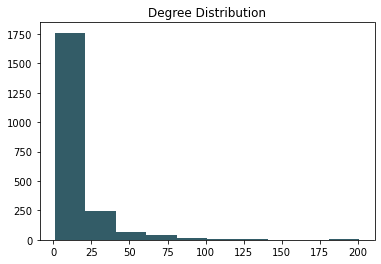

In [120]:
visualize1(G, '2008/08/01', '2008/08/15')


 ### <i> Visualization 2  - Visualize the best user! </i>
 
 Plot the input node and a subset of its neighbouring nodes such that the user can get a grasp of the importance of this input node. Also split the interval of time into equidistant ranges of time and show the metric evolution over time.


In [152]:
def visualization2(Graph, Node, start_date, end_date, Metric):
    
    # plot only the subset of the Node and its neighbors
    sub = [Node] + list(Graph.neighbors(Node))
    sub = [int(i) for i in sub]
    H = Graph.subgraph(sub)

    plt.figure(figsize = (10,8))
    plt.figure(1)
    plt.title(f'Node {Node} and its neighbours')
    color_map = ['#9e2a2b' if node == Node else '#e09f3e' for node in H]
    pos=nx.spring_layout(H,scale=2)
    nx.draw(H, with_labels = True, node_color=color_map,pos = pos, alpha = 0.7)
    
    

    score = []
    intervals = equi_intervals(start_date,end_date, 5) #equidistant ranges of time (5 intervals)
    
    for i in range(5):
        start = intervals[i]
        end = intervals[i+1]

        try:
            score.append(F2_BestUser(Graph, Node, Metric, start, end))
        except:
            score.append(0)
            
    inn = [f'{[intervals[i],intervals[i+1]]}' for i in range(len(intervals)-1)]

    plt.figure(2)
    plt.title('Score during time')

    plt.xticks(rotation=45, ha='right')
    plt.bar(inn, score, color = '#335c67')

The PageRank value of the node 42 is 0.0006976744186046513
The PageRank value of the node 42 is 0.0007611451657402828
The PageRank value of the node 42 is 0.00022026431718061678
The PageRank value of the node 42 is 0.00063283109145107


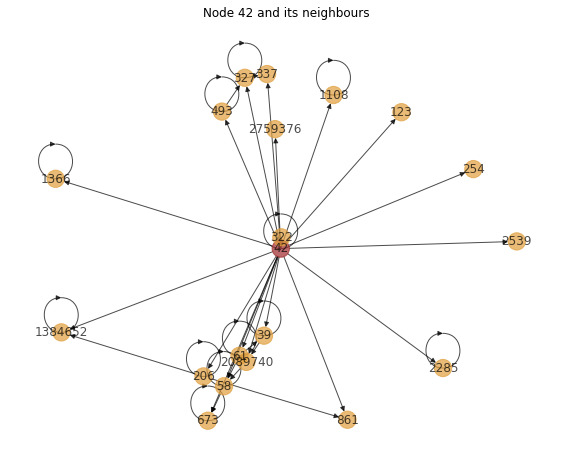

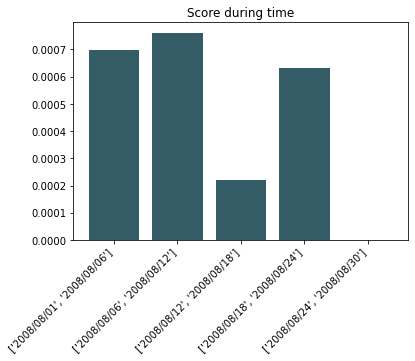

In [153]:
visualization2(G, 42, '2008/08/01', '2008/08/30', 'PageRank')

 ### <i> Visualization 3 - Visualize the Shortest Ordered Route </i>

 Once the user runs Functionality 3, we want the system to show in output the Shortest Ordered Route.

In [123]:
def visualize3(G,users,source,target):
    result = Shortest_Ordered_Route(G,users,source,target)
    print('Shortest Ordered Route:', result)
    
    route = result[1]
    G = nx.DiGraph()
    for i in range(len(route)-1):
        G.add_edge(route[i],route[i+1])
      
    pos = nx.layout.spring_layout(G)

    nx.draw_networkx_nodes(G, pos=pos, nodelist=[source],
                           node_color='#9e2a2b', label='Initial User', node_size = 800, alpha = 0.5)
    nx.draw_networkx_nodes(G, pos=pos, nodelist=[target],
                           node_color='#335c67', label='End User', node_size = 800, alpha = 0.5)
    nx.draw_networkx_nodes(G, pos=pos, nodelist=users,
                           node_color='#e09f3e', label='Users you must pass through', node_size = 800, alpha = 0.5)
    nx.draw_networkx_nodes(G, pos=pos, nodelist= result[1],
                           node_color='#fff3b0', label='Other users', node_size = 800, alpha = 0.5)
    
    plt.tight_layout()
    plt.legend(scatterpoints = 1, markerscale = 0.4)
    color_map = ['#9e2a2b' if node == source else '#335c67' if node == target else '#e09f3e' if node in users else '#fff3b0' for node in G]
    
    nx.draw(G, with_labels = True, node_color=color_map, alpha = 0.7, pos = pos, 
                          arrowsize=15, connectionstyle='arc3,rad=0.05', node_size = 800)

Shortest Ordered Route: (10, [1, 493, 721, 2, 1, 380, 2385, 5, 1063, 905, 8])


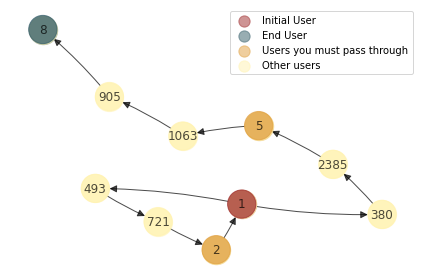

In [124]:
visualize3(G,[2,5],1,8)

 ### <i> Visualization 4 - Visualize disconnecting graphs </i>


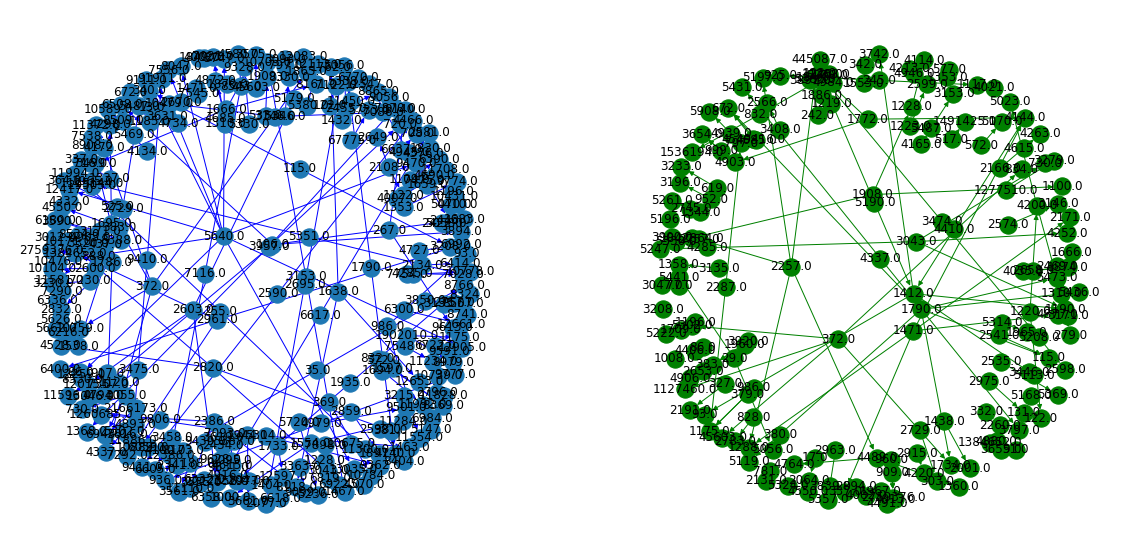

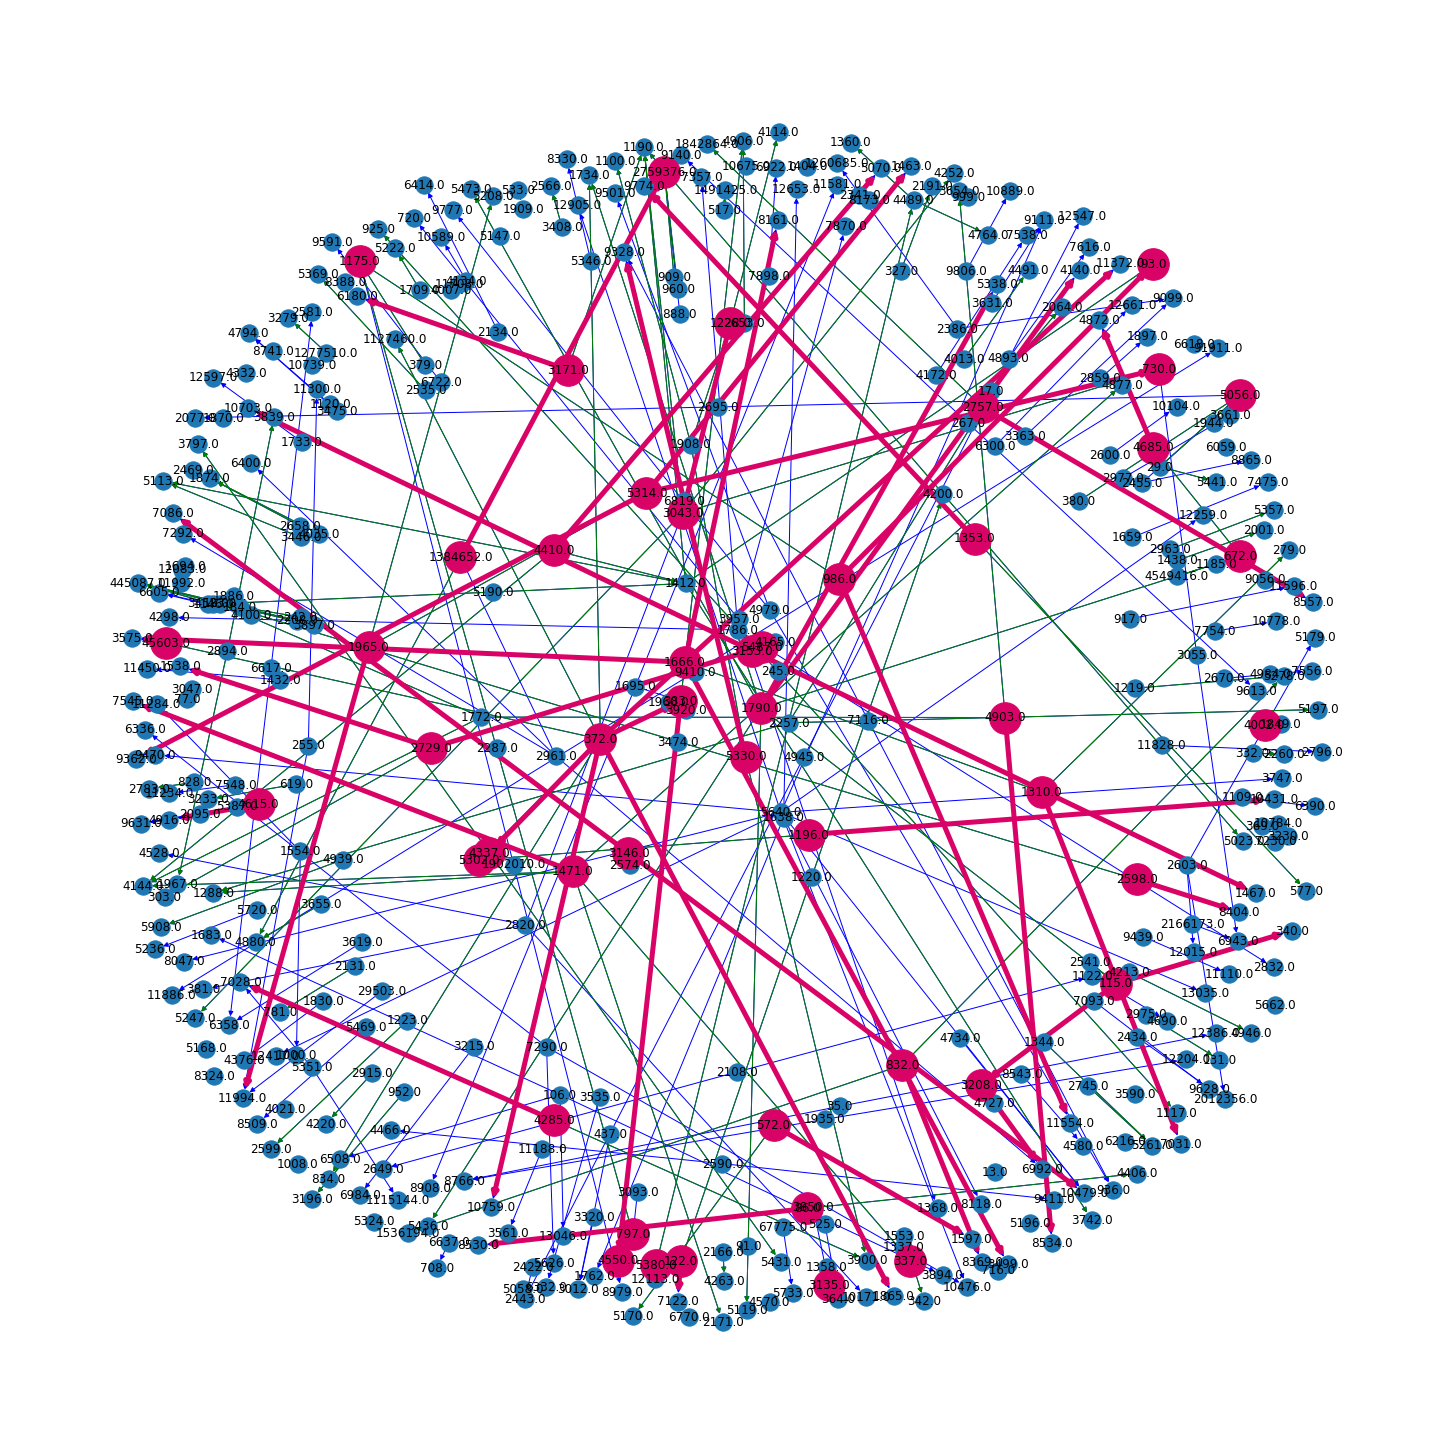

In [249]:
#return two graph and a list which contain the node which are in the intersection and  with the nodes forming an edge
MainGraph, SecondGraph, list_intersection, list_couples = F4_disconnectingGrapsh()

plt.figure(figsize=(20,10))
plt.subplot(121) 
nx.draw(MainGraph,with_labels = True, edge_color='blue',scale=4) #plot the main graph


plt.subplot(122) 
nx.draw(SecondGraph,with_labels = True, node_color='green', edge_color='green',scale=4) #plot the second graph


plt.figure(figsize=(20, 20))
mergeGraph = nx.compose(MainGraph, SecondGraph) #merge grahs
pos = nx.spring_layout(mergeGraph ) #save the position


#we recolor the nodes according to their graphs
nx.draw(mergeGraph,with_labels = True, pos=pos, edge_color='blue', scale=7)
nx.draw_networkx_edges(mergeGraph, pos=pos, edgelist=SecondGraph.edges(data=True), node_color = 'pink', edge_color='green')


#the purple nodes are the nodes that contain the links that must be removed
nx.draw_networkx_nodes(mergeGraph, nodelist=list_intersection, node_color = '#D90368', pos=pos, node_size=1000)
nx.draw_networkx_edges(mergeGraph, edgelist=list_couples, width=5.0,  pos=pos, edge_color='#D90368')
plt.show()

The first two figures represent the first and the second graph, the third figure represent the two graphs merged and the dots which are purple represent the points that are in the intersection in the two and, of course, the purple lines the links that need to be removed in order to disconnect the two graphs.
But! Sometimes you can see alone dots or not perfectly connected because some nodes are like a connection between two nodes, in other words two nodes of different graphs point to that node.

## 4. Algorithmic question

A number n of kids are in a camp. Between some k pairs of them (a kid can be part of more than one pairs) there are often fights. At night there are two dormitories where the kids can sleep. We want, if possible, to assign each kid in one of the two dormitories in such a way that each pair of kids that fights often is assigned to a different dormitory. (There are no space problems and the two dormitories can have different number of kids.)

Give an algorithm that is linear in n and k that is able to answer whether such an assignment is possible and, if so, return one.

*Solution*: The main idea is to use 3 list, oen for the first dormitory, one for the second dormitory and one for the kids who have already been triaged. Let's start by sorting out the kids who fight first and then all the others. After that check if each dormitory doesn't have fight kids inside. 

In [5]:
def separate_kids(kids, pairs_fight):
    dormitory_1 = []
    dormitory_2 = []
    checked_kids = []
    
    for pair in pairs_fight:
        if (pair[0] not in  checked_kids) and (pair[1] not in  checked_kids):
            dormitory_1.append(pair[0])
            dormitory_2.append(pair[1])
            checked_kids.append(pair[0])
            checked_kids.append(pair[1])
            
        elif (pair[0] in  checked_kids) and (pair[1] not in  checked_kids):
            if pair[0] in dormitory_1:
                dormitory_2.append(pair[1])
            else:
                dormitory_1.append(pair[1])
            checked_kids.append(pair[1])
            
        elif (pair[0] not in  checked_kids) and (pair[1] in  checked_kids):
            if pair[1] in dormitory_1:
                dormitory_2.append(pair[0])
            else:
                dormitory_1.append(pair[0])
            checked_kids.append(pair[0])
            
            
    for idx in range(0, len(kids)):
        if kids[idx] not in checked_kids:
            if idx%2:
                dormitory_1.append(kids[idx])
            else:
                dormitory_2.append(kids[idx])
                
    well_divided = True
    for pair in pairs_fight:
        if (pair[0] in dormitory_1) and (pair[1] in dormitory_1):
            print("It's impossible to divide the fighting kids in two dormitory")
            well_divided = False
        if (pair[0] in dormitory_2) and (pair[1] in dormitory_2):
            print("It's impossible to divide the fighting kids in two dormitory")
            well_divided = False
    
    if  well_divided:
        print('Solution found')
        print('\n First dormitory contains', dormitory_1)
        print('\n First dormitory contains', dormitory_2)


In [6]:
pairs = [(1,3),(4,1),(2,4),(2,1)]
kids = [1,2,3,4,5,6]
separate_kids(kids, pairs)

It's impossible to divide the fighting kids in two dormitory


In [8]:
pairs = [(5,3),(4,1),(2,4)]
kids = [1,2,3,4,5,6]
separate_kids(kids, pairs)

Solution found

 First dormitory contains [5, 4, 6]

 First dormitory contains [3, 1, 2]


In [9]:
pairs = [(6, 1), (8, 3), (7, 3), (6, 10)]
kids = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
separate_kids(kids, pairs)

Solution found

 First dormitory contains [6, 8, 7, 2, 4]

 First dormitory contains [1, 3, 10, 5, 9]
